# Surfs Up!
## Climate Analysis and Exploration
## Importing required libraries

In [1]:
%matplotlib inline 
from matplotlib import style
#FiveThirtyEight style of matplotlib
style.use('fivethirtyeight') 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Pandas - Python data analysis library
import datetime as dt # datetime module of Python

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy # Python SQL toolkit and ORM
from sqlalchemy.ext.automap import automap_base #Automatically generates mapped classes and relationships
from sqlalchemy.orm import Session #Establishes conversations with the database & “holding zone” for objects
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///resources/hawaii.sqlite",echo = False)

# Let's inspect the database

In [4]:
# Create the inspector and connect it to the engine
from sqlalchemy import inspect
inspector = inspect(engine)

In [5]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [6]:
# Get a list of column names and types from measurement table
columns = inspector.get_columns('measurement')
for col in columns:
    print(col['name'], col["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Get a list of column names and types from station table
columns = inspector.get_columns('station')
for col in columns:
    print(col['name'], col["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Reflecting the database into a new model

In [8]:
# We create a  new AutomapBase class using automap_base()
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Mapping measurement class
Measurement = Base.classes.measurement
# Mapping station class
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Checking session connection for both the tables¶

In [12]:
# Use the session to query Measurement table and display the first 5 rows
session.flush() # Forcing a flush
for row in session.query(Measurement.id, Measurement.station,Measurement.date,
                         Measurement.prcp,Measurement.tobs).limit(5).all():
    print(row)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)


In [13]:
# Use the session to query Station table and display the first 5 rows
session.flush() # Forcing a flush
for row in session.query(Station.id, Station.station,Station.name,Station.latitude,
                         Station.longitude,Station.elevation).limit(5).all():
    print(row)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)


# Exploratory Climate Analysis

## Precipitation Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [14]:
# Let's count the total dates we have
total_dates = session.query(func.count(Measurement.date)).first()
# Let's find the earliest date
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
# Let's find the latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Display the dates
print('\033[1m'+"There are {} dates, earliest date: {} and latest date: {}" .format(total_dates[0],earliest_date[0],latest_date[0])+'\033[0m')

There are 19550 dates, earliest date: 2010-01-01 and latest date: 2017-08-23


In [15]:
from datetime import timedelta
# Let's find date 12 months before the latest day
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Display the date
print('\033[1m'+"Date one year back: {}" .format(query_date)+'\033[0m')

Date one year back: 2016-08-23


## Perform a query to retrieve the data and precipitation scores

In [16]:
# Quering "date" and "precipitation" from Measurement table from past one year
Precipitation_one_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date)
# Let's print the first 10 results from the query
for row in Precipitation_one_year.limit(5).all():
    print(row)

('2016-08-23', 0.0)
('2016-08-24', 0.08)
('2016-08-25', 0.08)
('2016-08-26', 0.0)
('2016-08-27', 0.0)


## Creating a pandas dataframe

In [17]:
# Load the query results into a Pandas DataFrame 
df_prcp = pd.DataFrame(Precipitation_one_year, columns=['Date', 'Precipitation'])
# Sorting the DataFrame values by `date`
df_prcp.sort_values(by="Date", ascending=False)
# Display the precipitation dataframe
print('\033[1m'+"The shape of the {} dataframe is: {}" .format("precipitation",df_prcp.shape)+'\033[0m')
df_prcp.head() # Display the first 5 rows of the dataframe

The shape of the precipitation dataframe is: (2230, 2)


,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


## Making Date column as the index of the dataframe

In [18]:
# Dropping missing values from the dataframe
df_prcp.dropna(how='all',inplace = True)
# Let's convert the "Date" column to its proper format
df_prcp["Date"] = pd.to_datetime(df_prcp["Date"])
# Let's set the index to the date column
df_prcp.set_index("Date", inplace=True)
# Check if duplicate rows are dropped from the dataframe
print('\033[1m'+"The shape of the final {} dataframe is: {}" .format("precipitation",df_prcp.shape)+'\033[0m')
df_prcp.head()

The shape of the final precipitation dataframe is: (2230, 1)


,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


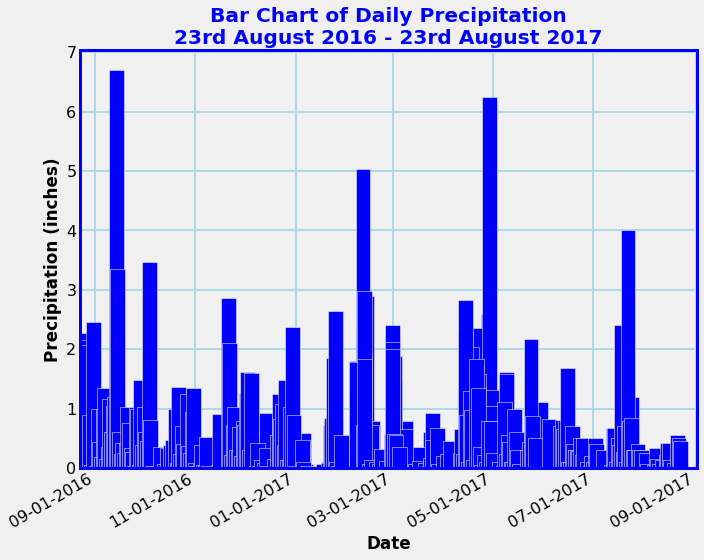

In [20]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import timedelta
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(df_prcp.index, df_prcp["Precipitation"],color = "blue", edgecolor="white",width = 9)
# Customize axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
# Customize axis spine
for spine in ax.spines.values():
    spine.set_edgecolor('blue')
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')    
    
# Set title and labels for axes
ax.set_xlabel("Date",color = "black",fontweight = "bold")
ax.set_ylabel("Precipitation (inches)",color="black",fontweight ="bold")
ax.set_title("Bar Chart of Daily Precipitation\n23rd August 2016 - 23rd August 2017",color="blue",fontweight = "bold")

plt.grid(color="lightblue",linestyle = "solid",linewidth = 2)

#Define the date format
date_form = DateFormatter("%m-%d-%Y")
ax.xaxis.set_major_formatter(date_form)
# Create upper date limit for x-axis
x_lim_date = dt.date(2017, 8, 23) + dt.timedelta(days=10)
ax.set_xlim(query_date,x_lim_date)

# Rotates and right aligns the x labels & moves the bottom of the axes to make room 
fig.autofmt_xdate()
plt.tight_layout()
# Save the figure
plt.savefig("Images/BarChart_Daily_Prcp.png")
plt.show()


## Creating a summary statistics for the precipitation data¶

In [21]:
# Padas.dataframe.describe generates descriptive statistics 
statistics = df_prcp.describe(include = [np.number])
# Let's make a dataframe from the summary statistics
df_statistics = pd.DataFrame(statistics)
# Formatting the float column
df_statistics = df_statistics.applymap("{0:.2f}".format)
# Rename the column
df_statistics.rename(columns={"Precipitation": "One_year_precipitation"}, inplace=True)
print('\033[1m'+"Shape of statistics dataframe for precipitation data is:{}" .format(df_statistics.shape)+'\033[0m')
df_statistics

Shape of statistics dataframe for precipitation data is:(8, 1)


,One_year_precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


# Station Analysis

### Design a query to calculate the total number of stations.

In [22]:
from sqlalchemy import distinct,func
# Let's count the total stations available in the dataset
total_stations = session.query(func.count(Station.station)).first()
distinct_stations = session.query(func.count(distinct(Station.station))).first()
# Display the count of total stations
print('\033[1m'+"There are {} stations and {} distinct stations" .format(total_stations[0],distinct_stations[0])+'\033[0m')

There are 9 stations and 9 distinct stations


# What are the most active stations? (i.e. what stations have the most rows)?

### List the stations and the counts in descending order.

In [23]:
# Let's design a query grouped by measurement stations and arranged in descending order
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                         order_by(func.count(Measurement.station).desc()).all()
# Load the query results into a Pandas DataFrame 
df_active_stations = pd.DataFrame(active_stations, columns=['Station', 'Count'])
# Display the active stations dataframe
print('\033[1m'+"The shape of {} dataframe is: {}" .format("active stations",df_active_stations.shape)+'\033[0m')
df_active_stations

The shape of active stations dataframe is: (9, 2)


,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


## Calculate the lowest temperature, highest temperature and average temperature from the most active station


In [25]:
# Let's get the most active station from the previous dataframe
most_active_station = df_active_stations.iloc[0,0]
# Display the active stations dataframe
print('\033[1m'+"The most active station is: {}" .format(most_active_station)+'\033[0m')

The most active station is: USC00519281


In [26]:
# Let's order the observed temperatures from Station # USC00519281 to check maximum and minimum values
Max_Temp = session.query(Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                 order_by(Measurement.tobs.desc()).limit(1).first()
Min_Temp = session.query(Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                 order_by(Measurement.tobs.asc()).limit(1).first()
# Display the maximum and minimum temperatures from the most active station
print('\033[1m'+"Observed temperatures from {} : Maximum {}F; Minimum {}F" .format(most_active_station,Max_Temp[0],Min_Temp[0])+'\033[0m')

Observed temperatures from USC00519281 : Maximum 85.0F; Minimum 54.0F


In [27]:
# Let's get the maximum, minimum and average temperatures using function method
from sqlalchemy import func
Max_Temp = session.query(func.max(Measurement.tobs).label("Max_Temp")).\
                filter(Measurement.station == most_active_station).first()
Min_Temp = session.query(func.min(Measurement.tobs).label("Min_Temp")).\
                filter(Measurement.station == most_active_station).first()
Avg_Temp = session.query(func.avg(Measurement.tobs).label("Avg_Temp")).\
                filter(Measurement.station == most_active_station).first()
data_list = [[most_active_station,Max_Temp[0],Min_Temp[0],round(Avg_Temp[0],2)]]
df_most_active_station = pd.DataFrame(data_list,columns = ["Most Active Station","Max. Temp(F)","Min. Temp(F)","Avg. Temp(F)"])
df_most_active_station

,Most Active Station,Max. Temp(F),Min. Temp(F),Avg. Temp(F)
0,USC00519281,85.0,54.0,71.66


### Choose the station with the highest number of temperature observations.

In [29]:
# Let's design a query grouped by temperature observations and arranged in descending order
temp_stations = session.query(Measurement.station,func.count(Measurement.tobs)).\
                        group_by(Measurement.station).\
                         order_by(func.count(Measurement.tobs).desc()).all()
# Load the query results into a Pandas DataFrame 
df_temp_stations = pd.DataFrame(temp_stations, columns=['Station', 'Count'])
# Display the active stations dataframe
print('\033[1m'+"The shape of {} dataframe is: {}" .format("temperature stations",df_temp_stations.shape)+'\033[0m')
df_temp_stations

The shape of temperature stations dataframe is: (9, 2)


,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


### Query the last 12 months of temperature observation data for this station

In [30]:
# Let's get the most active station from the previous dataframe
most_temp_station = df_temp_stations.iloc[0,0]
# Quering "date" and "precipitation" from Measurement table from past one year
Temp_one_year = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= query_date).\
                        filter(Measurement.station == most_temp_station)
# Load the query results into a Pandas DataFrame 
df_temp = pd.DataFrame(Temp_one_year, columns=['Date', 'Temperature'])
# Display the active stations dataframe
print('\033[1m'+"Shape of {} dataframe with temperature readings for past 12 months: {}" .format(most_temp_station,df_temp.shape)+'\033[0m')
df_temp.head() # Display the first 5 rows


Shape of USC00519281 dataframe with temperature readings for past 12 months: (352, 2)


,Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


### Create a histogram of the observed temperature data

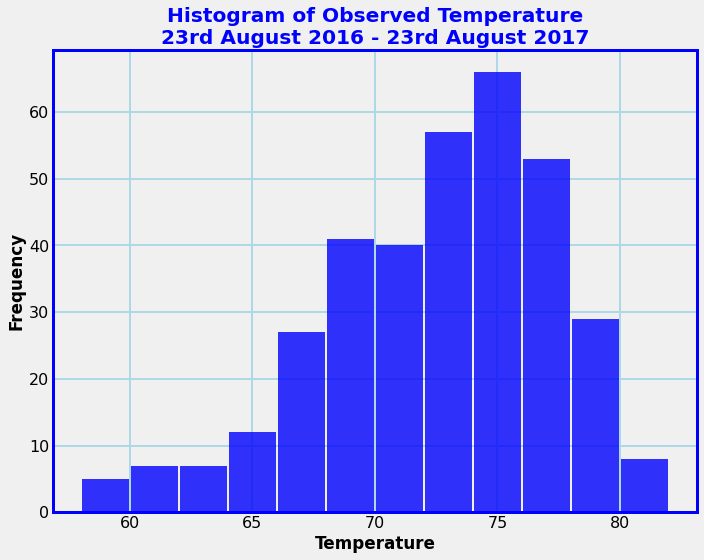

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 8))
# Define the number of bins
number_of_bins = 12
# Define the data
x = df_temp["Temperature"]
# Create the plot
n, bins, patches = ax.hist(x, color="blue", bins=number_of_bins, align="left",alpha=0.8,rwidth = 0.95)
# Customize axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
# Customize axis spine
for spine in ax.spines.values():
    spine.set_edgecolor('blue')
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')    
    
# Set title and labels for axes
ax.set_xlabel("Temperature",color = "black",fontweight = "bold")
ax.set_ylabel("Frequency",color="black",fontweight ="bold")
ax.set_title("Histogram of Observed Temperature\n23rd August 2016 - 23rd August 2017",color="blue",fontweight = "bold")

plt.grid(color="lightblue",linestyle = "solid",linewidth = 2)
plt.tight_layout()
# Save the figure
plt.savefig("Images/Histogram_Obs_Temp.png")
plt.show()

# Bonus: Temperature Analysis I

## Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

### Identify the average temperature in June from all stations across all available years in the dataset

In [32]:
# Let's design a query of average temperature and average precipitation in June across all available years
June_weather = session.query(func.avg(Measurement.prcp),func.avg(Measurement.tobs)).\
                           filter(func.strftime("%m", Measurement.date) == "06").all()
# Load the query results into a Pandas DataFrame 
df_June = pd.DataFrame(June_weather, columns=['Avg. Precipitation', 'Avg. Temperature'])
# Display the average June weather dataframe
df_June

,Avg. Precipitation,Avg. Temperature
0,0.13636,74.944118


## Identify the average temperature in December from all stations across all available years in the dataset

In [33]:
# Let's design a query of average temperature and average precipitation in June across all available years
Dec_weather = session.query(func.avg(Measurement.prcp),func.avg(Measurement.tobs)).\
                           filter(func.strftime("%m", Measurement.date) == "12").all()
# Load the query results into a Pandas DataFrame 
df_Dec = pd.DataFrame(Dec_weather, columns=['Avg. Precipitation', 'Avg. Temperature'])
# Display the average June weather dataframe
df_Dec

,Avg. Precipitation,Avg. Temperature
0,0.216819,71.041529


# Paired vs. Unpaired t-test

## A paired t-test is designed to compare the means of the same group or item under two separate scenarios.

### An unpaired t-test compares the means of two independent or unrelated groups.

In [34]:
# Let's design a query of observed temperatures in June across all available years
June_temp = session.query(Measurement.tobs).\
                           filter(func.strftime("%m", Measurement.date) == "06").all()
# Filter out null values from the June_Temp
June_list = [] # Create a new list
for temp in June_temp: # Append to the new list
    if type(temp.tobs) != 0:
        June_list.append({"Temperature":temp.tobs})
# Let's design a query of observed temperatures in December across all available years
Dec_temp = session.query(Measurement.tobs).\
                           filter(func.strftime("%m", Measurement.date) == "12").all()
# Filter out null values from the June_Temp
Dec_list = [] # Create a new list
for temp in Dec_temp: # Append to the new list
    if type(temp.tobs) != 0:
        Dec_list.append({"Temperature":temp.tobs})
# Display the length of both list
print('\033[1m'+"Length of June and December lists are {} and {} respectively".format(len(June_list),len(Dec_list))+'\033[0m')

Length of June and December lists are 1700 and 1517 respectively


In [35]:
# Let's create a DataFrame for the month of June with June list of temperatures
df_June = pd.DataFrame(June_list)
# Rename the column
df_June.rename(columns={"Temperature": "June"}, inplace=True)
# Let's create a DataFrame for the month of December with December list of temperatures
df_Dec = pd.DataFrame(Dec_list)
# Rename the column
df_Dec.rename(columns={"Temperature": "December"}, inplace=True)
# Merge the two dataframe into a single dataframe
df_combined = pd.merge(df_June, df_Dec, left_index=True, right_index=True)
df_combined.head() # Display the first 5 rows

,June,December
0,78.0,76.0
1,76.0,74.0
2,78.0,74.0
3,76.0,64.0
4,77.0,64.0


## Box Plot of observed temperatures in June vs. December


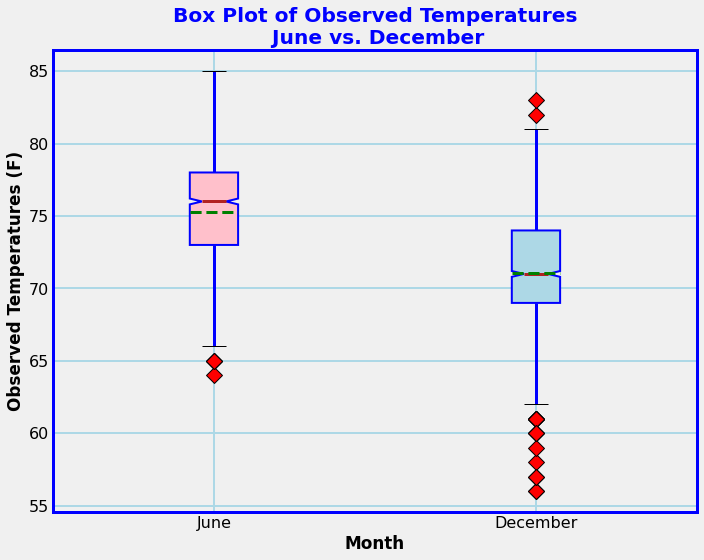

In [36]:
import numpy as np
import matplotlib.pyplot as plt
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 8))
box_data = [df_combined["June"],df_combined["December"]]
# Creating artist customisation
boxprops = dict(linestyle='-', linewidth=2, color='blue')
medianprops = dict(linestyle='-', linewidth=3, color='firebrick')
red_diamond = dict(markerfacecolor='r', marker='D', markersize = 12)
meanlineprops = dict(linestyle='--', linewidth=3, color='green')
lineprops = {'color': 'b', 'linewidth': 3}
# Create the plot
bplot = ax.boxplot(box_data,labels=["June","December"],notch=True,\
           flierprops=red_diamond,boxprops=boxprops,\
           medianprops=medianprops,meanline=True,whiskerprops = lineprops,\
           showmeans=True,meanprops=meanlineprops,patch_artist=True
          )
# fill with colors
colors = ['pink', 'lightblue']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
# Customize axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
# Customize axis spines
for spine in ax.spines.values():
    spine.set_edgecolor('blue')
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')    
    
# Set title and labels for axes
ax.set_xlabel("Month",color = "black",fontweight = "bold")
ax.set_ylabel("Observed Temperatures (F)",color="black",fontweight ="bold")
ax.set_title("Box Plot of Observed Temperatures\n June vs. December",color="blue",fontweight = "bold")
plt.grid(color="lightblue",linestyle = "solid",linewidth = 2)
plt.tight_layout()
# Save the figure
plt.savefig("Images/BoxPlot_Obs_Temp.png")
plt.show()

## Unpaired (independent) t-test between observed temperatures in June vs. December

In [37]:
# Necessary imports for statistical analysis
from scipy import stats
from scipy import mean
# Unpaired (independent) t-test
result = stats.ttest_ind(df_combined["June"],df_combined["December"])
# Display t-test result
print('\033[1m'+"Calculated t-statistic: {} and two-tailed p-value: {}".format(result[0],result[1])+'\033[0m')

Calculated t-statistic: 33.85138883503442 and two-tailed p-value: 2.3336388855232838e-213


# Bonus: Temperature Analysis II

## "calc_temps" function that returns min, max and avg. temperatures for a list of dates

### Arguments : start_date & end_date (string): A date string in the format %Y-%m-%d

#### Returns: TMIN, TAVG, and TMAX

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
           filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Let's choose a start date and end date for our trip.

#### Start Date : 2017-07-03
#### End Date : 2017-07-17

In [39]:
# Let's define the start and end days of our trip
start_date = dt.date(2017,7,3) # Start date
end_date = dt.date(2017,7,17) # End date
# Let's find the minimum, maximum and average temperatures during our trip
trip_temp = calc_temps(start_date,end_date)
# Display the temperatures
print('\033[1m'+"Min. Temp: {}F, Avg. Temp: {}F and Max. Temp: {}F".format(trip_temp[0][0],round(trip_temp[0][1],1),trip_temp[0][2])+'\033[0m')

Min. Temp: 69.0F, Avg. Temp: 78.2F and Max. Temp: 87.0F


In [40]:
# Load the query results into a Pandas DataFrame 
df_trip_temp = pd.DataFrame(trip_temp, columns=["Min_Temp","Avg_Temp","Max_Temp"])
# Let's create a peak-peak temperature column
df_trip_temp["Max_Min"] = df_trip_temp["Max_Temp"] - df_trip_temp["Min_Temp"]
# Display the dataframe
df_trip_temp

,Min_Temp,Avg_Temp,Max_Temp,Max_Min
0,69.0,78.221053,87.0,18.0


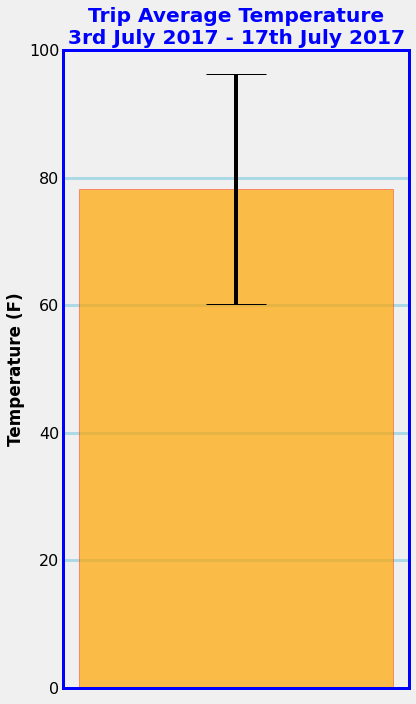

In [41]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Create figure and plot space
fig, ax = plt.subplots(figsize=(6, 10))

ax.bar(0,df_trip_temp["Avg_Temp"],yerr=df_trip_temp["Max_Min"],color = "orange", alpha = 0.7,edgecolor="red",capsize=30)
# Customize axis labels
ax.tick_params(axis='both', which='major', labelsize=16)
# Customize axis spines
for spine in ax.spines.values():
    spine.set_edgecolor('blue')
for tick in ax.get_xticklabels():
    tick.set_color('black')
for tick in ax.get_yticklabels():
    tick.set_color('black')    
    
# Set title and labels for axes
ax.get_xaxis().set_visible(False)
ax.set_ylim(0,100)
ax.set_ylabel("Temperature (F)",color="black",fontweight ="bold")
ax.set_title("Trip Average Temperature\n3rd July 2017 - 17th July 2017",color="blue",fontweight = "bold")

plt.grid(color="lightblue",linestyle = "solid",linewidth = 3)
plt.tight_layout()
# Save the figure
plt.savefig("Images/Trip_Avg_Temp.png")
plt.show()

# Bonus: Daily Rainfall

## Calculate the total amount of rainfall per weather station for our trip dates.
### Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#### Total precipitation per weather station for our trip duration

In [42]:
# Let's design a list of query items
query_items = [func.sum(Measurement.prcp),Station.station,Station.name,\
        Station.latitude,Station.longitude,Station.elevation]
# Let's create the query by joining Measurement and Station tables
results = session.query(*query_items).group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).\
              outerjoin(Station, Station.station==Measurement.station).\
                 filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# Load the query results into a Pandas DataFrame 
df_precipitation = pd.DataFrame(results, columns=["Total_prcp","Station_id","Station_name","Latitude","Longitude","Elevation"])
df_precipitation

,Total_prcp,Station_id,Station_name,Latitude,Longitude,Elevation
0,3.16,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,1.72,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,0.91,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,0.67,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,0.22,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,0.13,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,NaN,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


# Average temperature per weather station for our trip duration

In [43]:
# Let's design a list of query items
query_items = [func.avg(Measurement.tobs),Station.station,Station.name,\
        Station.latitude,Station.longitude,Station.elevation]
# Let's create the query by joining Measurement and Station tables
results = session.query(*query_items).group_by(Measurement.station).\
            order_by(func.avg(Measurement.tobs).desc()).\
              outerjoin(Station, Station.station==Measurement.station).\
                 filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# Load the query results into a Pandas DataFrame 
df_temperature = pd.DataFrame(results, columns=["Avg_Temp","Station_id","Station_name","Latitude","Longitude","Elevation"])
df_temperature

,Avg_Temp,Station_id,Station_name,Latitude,Longitude,Elevation
0,80.625000,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
1,80.461538,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,80.428571,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,79.666667,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,77.000000,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
5,75.800000,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
6,75.133333,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


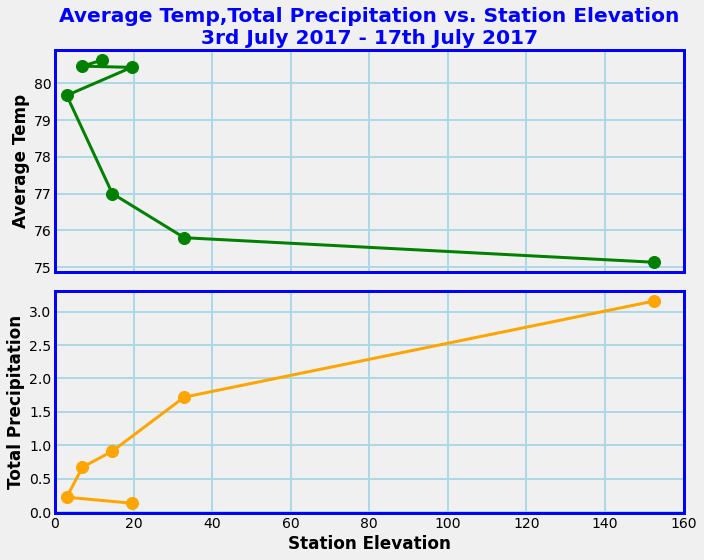

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure and plot space
fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(10,8))
# Create the plot
ax1.plot(df_temperature["Elevation"],df_temperature["Avg_Temp"],color="green",\
         marker='o',markersize=12,linewidth = 3)
ax2.plot(df_precipitation["Elevation"],df_precipitation["Total_prcp"],color="orange",\
         marker='o',markersize=12,linewidth = 3)
# Customize axis labels
ax.tick_params(axis='both', which='major', labelsize=18)
# Customize axis spine
for ax in (ax1,ax2):
    for spine in ax.spines.values():
        spine.set_edgecolor('blue')
    for tick in ax.get_xticklabels():
        tick.set_color('black')
    for tick in ax.get_yticklabels():
        tick.set_color('black')       
# Set title and labels for axes
ax2.set_xlabel("Station Elevation",color = "black",fontweight = "bold")
ax1.set_ylabel("Average Temp",color="black",fontweight ="bold")
ax2.set_ylabel("Total Precipitation",color="black",fontweight ="bold")
ax1.set_title("Average Temp,Total Precipitation vs. Station Elevation\n3rd July 2017 - 17th July 2017",color="blue",fontweight = "bold")
# Setting x-limits
ax1.set_xlim(0,160)
# Customizing grid for subplots
for ax in (ax1,ax2):
    ax.grid(color="lightblue",linestyle = "solid",linewidth = 2)
plt.tight_layout()
# Save the figure
plt.savefig("Images/Avg_Temp_Prcp.png")
plt.show()


# Observations from Average temperature & Precipitation study
### Precipitation is higher for stations with higher elevation
##### Average Temperature decreases with increasing station elevation



# Bonus: Daily Normals
### "daily normal" function that returns min, max and avg. temperatures for a date
#### Arguments : date (string): A date string in the format %m-%d
##### Returns: A list to tuples containing the daily normals TMIN, TAVG, and TMAX

In [45]:
# Function "daily_normals" - returns a tuple of min, avg. and max observed temperature of a particular date
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [46]:
from datetime import timedelta
#Let's create a list of dates corresponding to our trip
Trip_Dates = [start_date - dt.timedelta(days=-x) for x in range(15)]
#Let's convert the dates into correct format
trip_dates = [date.strftime("%m-%d") for date in Trip_Dates]
# Let's calculate normals for each date in the list
normals = [daily_normals(date) for date in trip_dates]
# Since normals is a list of lists, let's flatten it
trip_normals = [item for sublist in normals for item in sublist]
# Load trip_normals into a Pandas DataFrame with index from trip_dates
df_trip_normals = pd.DataFrame(trip_normals,index = Trip_Dates, columns=["Min_Temp","Avg_Temp","Max_Temp"])
# Display the dataframe
df_trip_normals

,Min_Temp,Avg_Temp,Max_Temp
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0
2017-07-06,69.0,75.000000,81.0
2017-07-07,69.0,74.910714,82.0
2017-07-08,69.0,76.083333,83.0
2017-07-09,68.0,76.192982,83.0
2017-07-10,68.0,75.620690,82.0
2017-07-11,70.0,75.789474,81.0
2017-07-12,67.0,75.964912,82.0


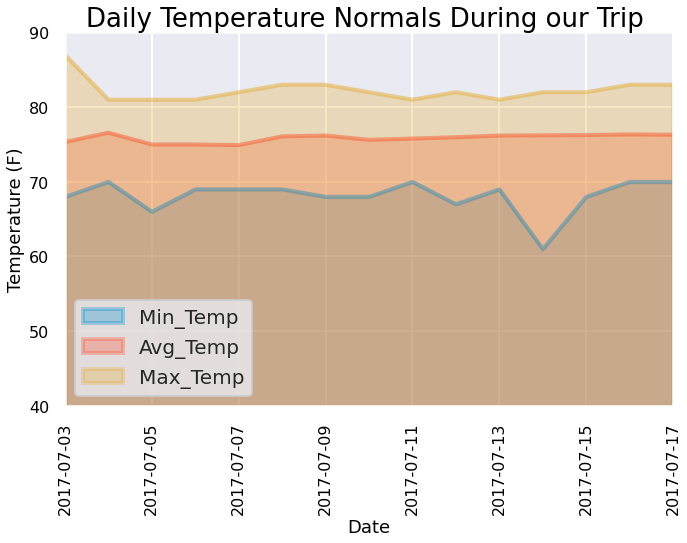

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a font library
titlefont = {"fontname":"Times New Roman"}

# Set the style for seaborn plot
sns.set_style("darkgrid")
# Set font scale and reduce grid line width
sns.set_context("poster",font_scale=0.9, rc={"grid.linewidth":2})
# Define the figure size
df_trip_normals.plot(kind="area",stacked=False,rot=90,alpha=0.3,linewidth=4,figsize=(10,8))
# Display x & y-axis labels and a title for the area plot
plt.title("Daily Temperature Normals During our Trip ",fontsize=26,color="black",**titlefont)
plt.xlabel("Date",fontsize = 18,color="black",**labelfont)
plt.ylabel("Temperature (F)",fontsize = 18,color="black",**labelfont)
# Setting x & y-limits
plt.ylim(40,90)
plt.xlim('2017-07-03','2017-07-17')
# Customizing x & y-ticks
plt.xticks(color="black",fontsize=16,**labelfont)
plt.yticks(color="black",fontsize=16,**labelfont)
# Customize the legend
plt.legend(loc="best",prop={'size':20})
plt.tight_layout()
# Save the figure
plt.savefig("Images/AreaPlot_Temp_Normals.png")
plt.show()